# Homework 3 - Species Balance Equations - Part II


In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os
#import time
import matplotlib as mpl

import sys
module_path = './modules'
sys.path.append(module_path)

from simulate import Simulation

#reload modules before running
%load_ext autoreload
%autoreload 2

In [2]:
cti_path = './cti_files'
os.listdir(cti_path)

['pcfc_11072018.cti',
 'pcfc_11072018_Rxns1,2,2b,3.cti',
 'pcfc_11072018_Rxns1,2,3.cti',
 'pcfc_11072018_Rxns1,3.cti',
 'pcfc_JH.cti']

There are 3 CTI files that I'm trying to test. All three have the same thermo, but different sets of reactions enabled, as indicated in the file names. The reactions are as follows:

$$
\begin{align}
    &1. \quad {\rm OH}_{\rm el(b)} + {\rm O}_{\rm ca(b)} \leftrightharpoons {\rm O}_{\rm el(b)} + {\rm OH}_{\rm ca(b)} \\
    &2. \quad {\rm OH}_{\rm ca(b)} + {\rm O}_{\rm ca(s)} \leftrightharpoons {\rm O}_{\rm ca(b)} + {\rm OH}_{\rm ca(s)} \\
    &2{\rm b}. \quad{\rm Vac}_{\rm ca(b)} + {\rm O}_{\rm ca(s)} \leftrightharpoons {\rm O}_{\rm ca(b)} + {\rm Vac}_{\rm ca(s)} \\
    &3. \quad {\rm H_2 O}_{\rm (g)} + {\rm Vac}_{\rm ca(s)} + {\rm O}_{\rm ca(s)} \leftrightharpoons 2\, {\rm OH}_{\rm ca(s)}
\end{align}
$$

In [3]:
ctifile1 = os.path.join(cti_path,'pcfc_11072018_Rxns1,3.cti') #only rxns 1 & 3 turned on
ctifile2 = os.path.join(cti_path,'pcfc_11072018_Rxns1,2,3.cti') #rxns 1, 2, & 3 turned on
ctifile3 = os.path.join(cti_path,'pcfc_11072018_Rxns1,2,2b,3.cti') #rxns 1, 2, 2b, & 3 turned on
ctifiles = [ctifile1, ctifile2, ctifile3]
prefix = 'pcfc_11072018_'

def ctifile_label(file,prefix):
    return os.path.basename(file).strip(prefix).strip('.cti')

I use the `Simulation` class to wrap up most of the complexity in the model. This pulls from the `analysis`, `calc`, and `wrappers` modules, but most of the important stuff is in the `simulate` module (which contains the `Simulation` class). An overview is in the README, and detailed documentation is in the module .py files.

Help on Simulation in module simulate object:

class Simulation(builtins.object)
 |  Class for initializing, running, and plotting simulations
 |  
 |  Methods defined here:
 |  
 |  __init__(self, derivative_func=<function derivative at 0x15174f4730>)
 |      Initialization
 |      
 |      Parameters:
 |      -----------
 |      derivative_func: solution vector derivative function
 |  
 |  clear_runs(self)
 |      Clear saved run data
 |  
 |  init_SV(self, charge_balance)
 |      Get initial solution vector
 |      Determined from sim_params and current state of phases and interfaces
 |      
 |      Parameters:
 |      -----------
 |      charge_balance: if True, impose charge balance
 |      
 |      Returns initial solution vector
 |  
 |  initialize(self, ctifile, set_params=True)
 |      Initialize default parameters and load phases
 |      
 |      Parameters:
 |      -----------
 |      ctifile: CTI file from which to import phases and interfaces
 |      set_params: if True, 

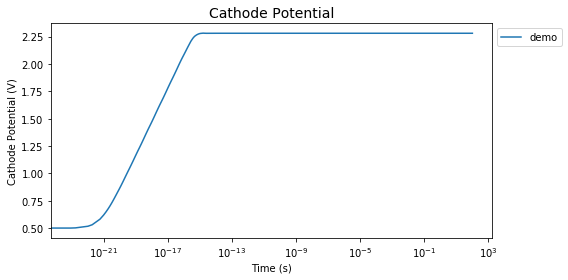

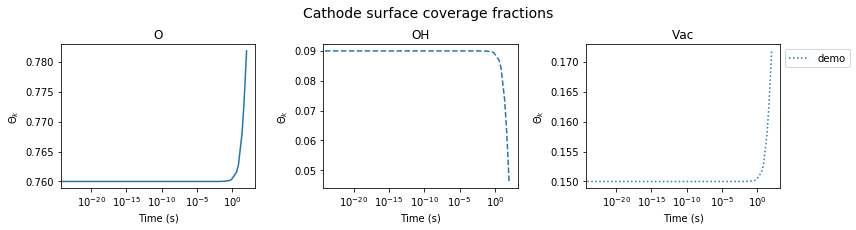

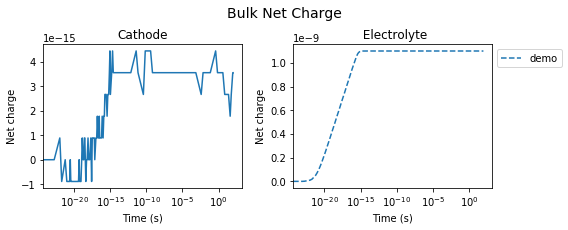

In [10]:
"Overview of Simulation class"
sim = Simulation()
#load phases and interfaces, set default parameters
sim.initialize(ctifile1) 
#if desired, set parameters to non-default values
sim.user_params['Phi_BCFZY_init'] = 0.5
#run simulation. can specify charge balance on/off, static variables, initial SV
sim.run([0,1e2], charge_balance=True, static=['rho_gas'],save_as = 'demo') 
#plot run results. sets of plots can be excluded if irrelevant
axes = sim.plot_runs(plot_func='semilogx',exclude=['Y_gas','X_ca','X_elyte'])
#most methods and attributes are documented
help(sim)

First, running with everything turned on, I get some odd behavior, but nothing seems to blow up too badly.

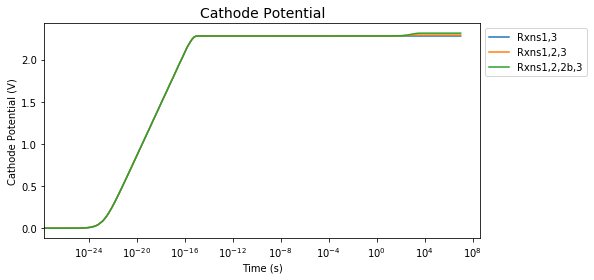

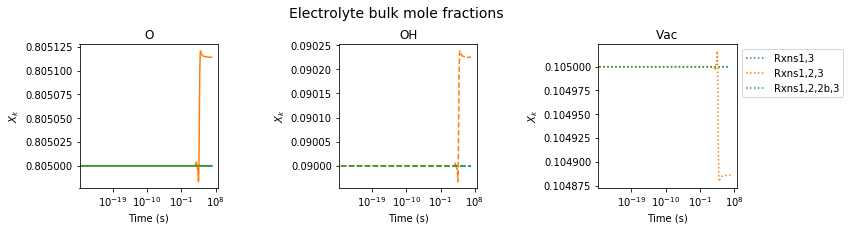

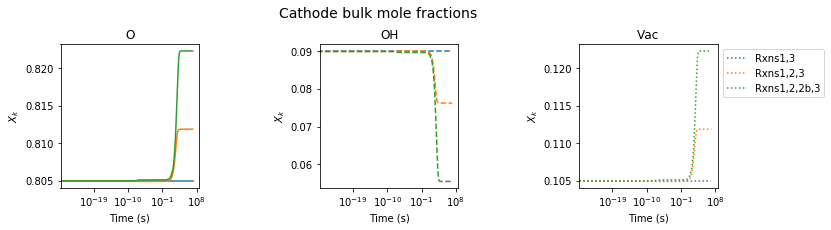

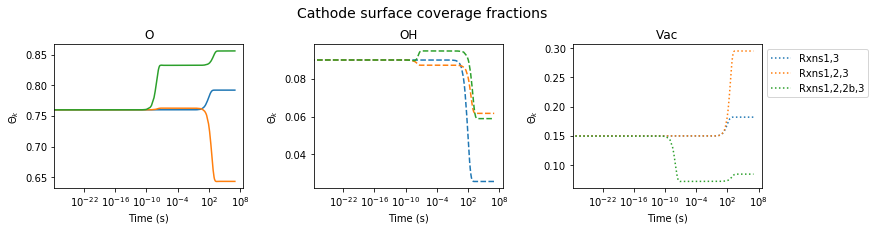

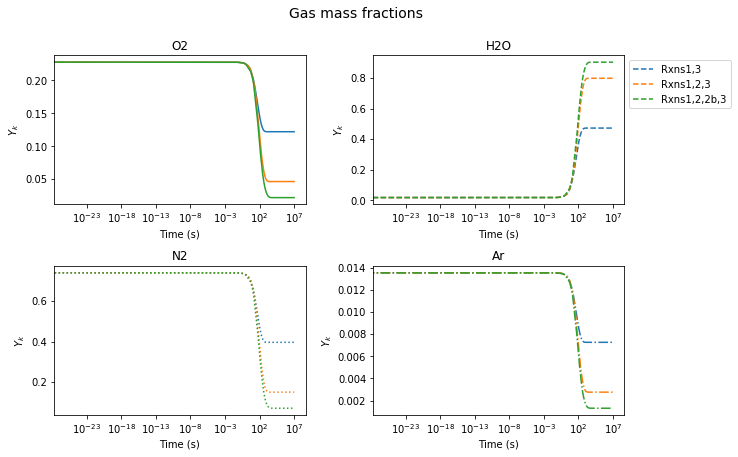

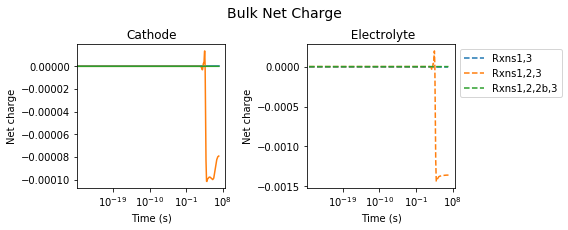

In [13]:
#run with charge balance, all derivatives turned on
sim1 = Simulation()
t_span = [0,1e7]

for cf in ctifiles:
    sim1.initialize(cf)
    label = ctifile_label(cf,prefix)
    sim1.run(t_span, charge_balance=True,save_as = label)

axes = sim1.plot_runs(plot_func='semilogx')

A lot of gaseous water is evolved, which significantly impacts the gas composition since there is not gas transport incorporated into the model at this point. It may make sense to leave the gas composition constant for now.

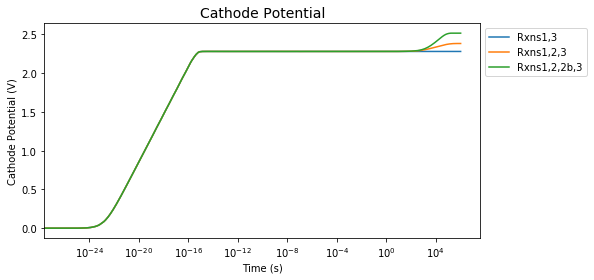

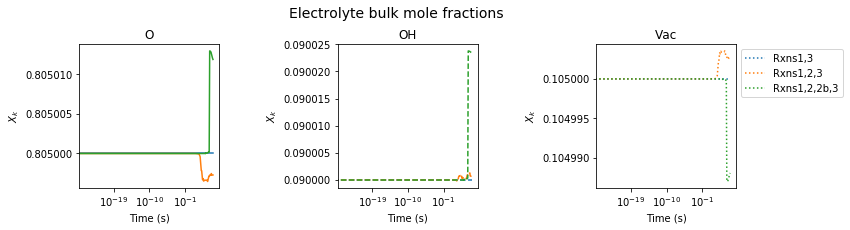

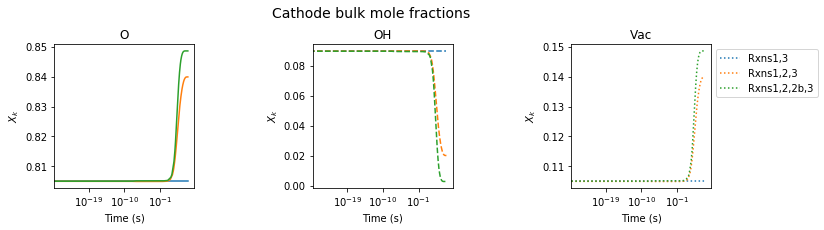

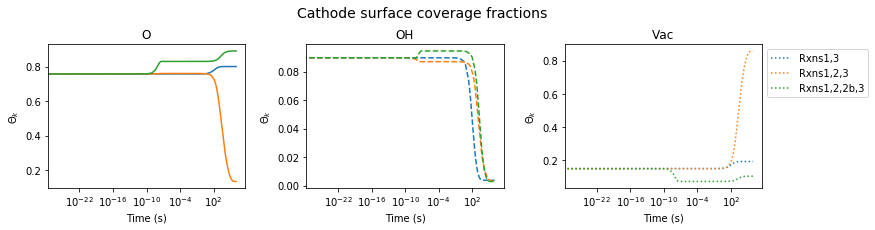

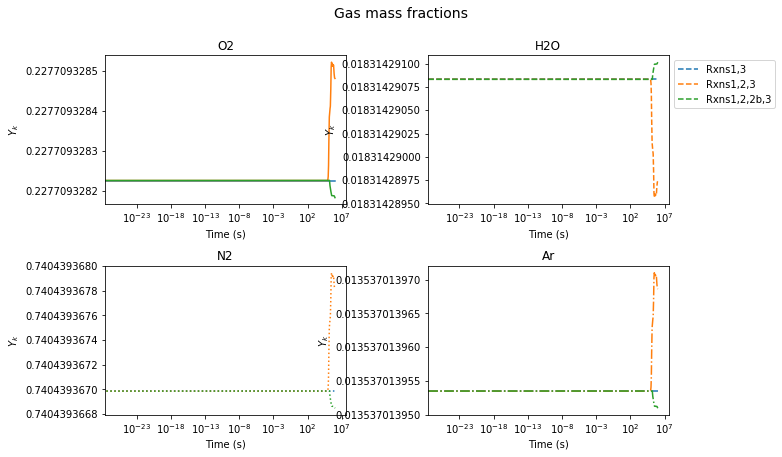

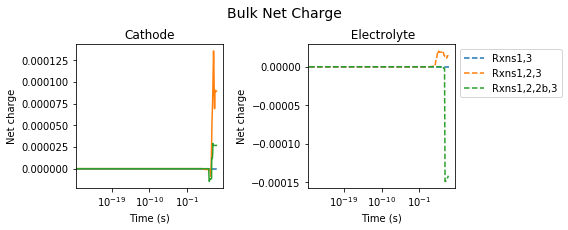

In [16]:
#run with constant gas composition
sim3 = Simulation()
t_span = [0,1e6]

for cf in ctifiles:
    sim3.initialize(cf)
    label = ctifile_label(cf,prefix)
    sim3.run(t_span, charge_balance=True,static=['rho_gas'],save_as = label)

axes = sim3.plot_runs(plot_func='semilogx',exclude=['rho_gas'])

There are still some changes in gas mass fractions, but they are negligibly small. I attribute these to numerical oddities in `solve_ivp`, since the derivatives for $\rho_{k,{\rm gas}}$ are explicitly set to zero.
Running with charge balance may produce odd results because it imposes constraints on the O-site species mole fractions that may be at odds with species production rates. However, simply turning off the charge balance results in the accumulation of significant net charge in the cathode and electrolyte bulk phases, as shown below.

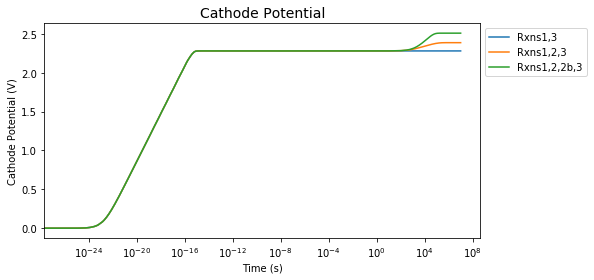

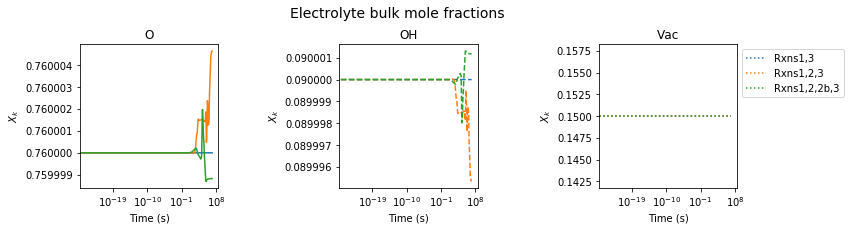

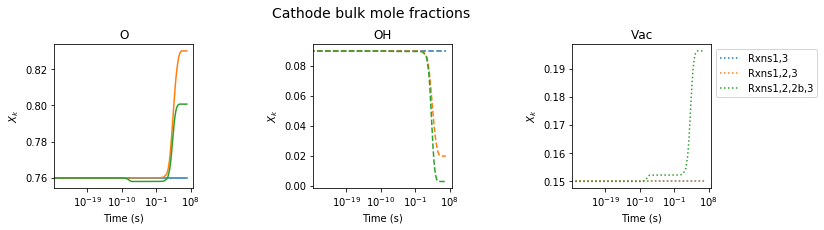

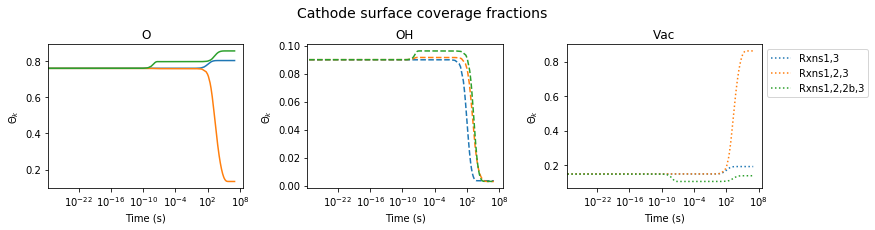

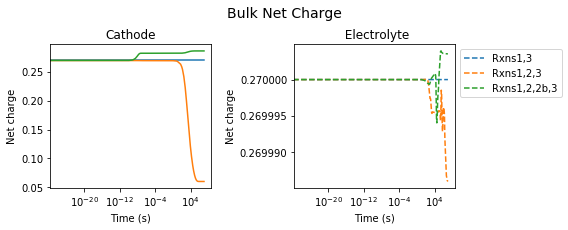

In [18]:
#run with charge balance off, constant gas composition
sim2 = Simulation()
t_span = [0,1e7]

for cf in ctifiles:
    sim2.initialize(cf)
    label = ctifile_label(cf,prefix)
    sim2.run(t_span, charge_balance=False,static=['rho_gas'],save_as = label)

axes = sim2.plot_runs(plot_func='semilogx', exclude=['Y_gas']) #don't plot gas mass fractions

While the bulk phases begin with substantial net charge, for the most part there is little deviation from this initial state. Thus I tried initializing the simulation with charge balance, and then running without the charge balance constraint from this balanced starting point. However, the only CTI file that maintains charge-neutral bulk phases is the one with only reactions 1 and 3 enabled.

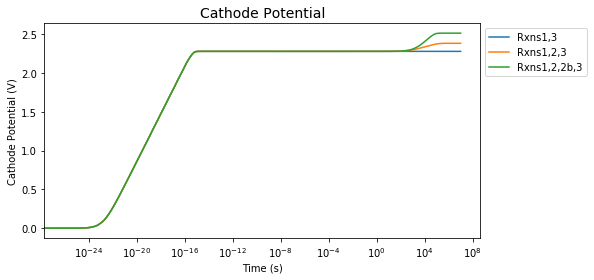

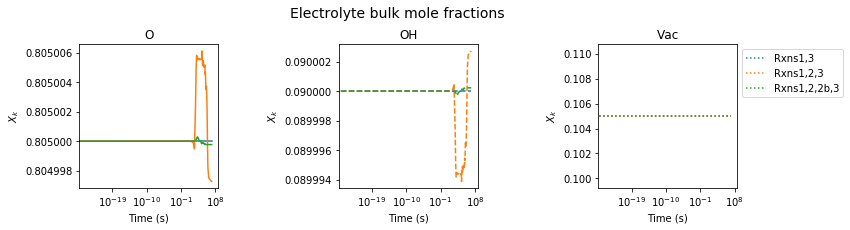

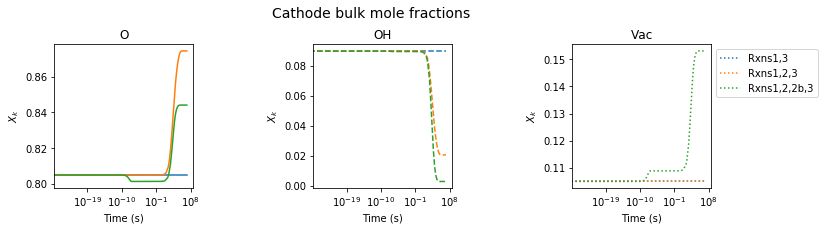

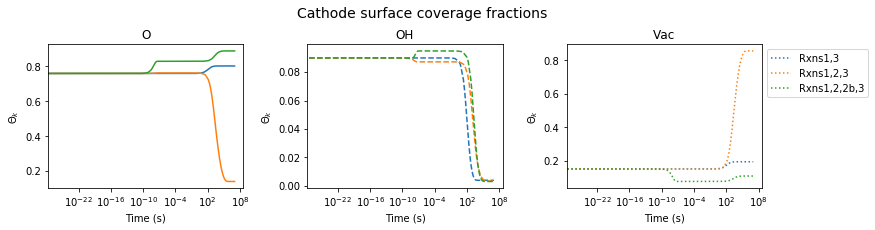

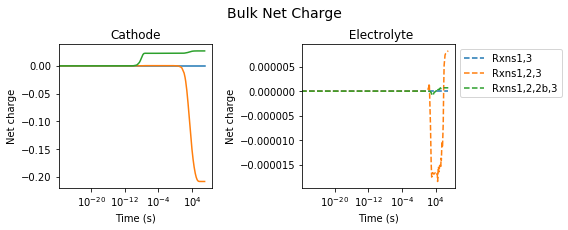

In [20]:
#initialize with charge balance, then run without charge balance
sim4 = Simulation()
t_equil = [0,1e-20]
t_span = [0,1e7]

for cf in ctifiles:
    sim4.initialize(cf)
    label = ctifile_label(cf,prefix)
    sim4.run(t_equil, charge_balance=True)
    sim4.run(t_span, charge_balance=False,static=['rho_gas'],save_as = label)

axes = sim4.plot_runs(plot_func='semilogx',exclude=['Y_gas'])
#only the second run (post-equilibration) is plotted for each cti file

I finally tried what we discussed in office hours, which was to first equilibrate the cathode and gas phases without charge balance, and then fix this composition while imposing charge balance and equilibrating the cathode-electrolyte potential difference.

Rxns1,3
Rxns1,2,3
Rxns1,2,2b,3
simulations done


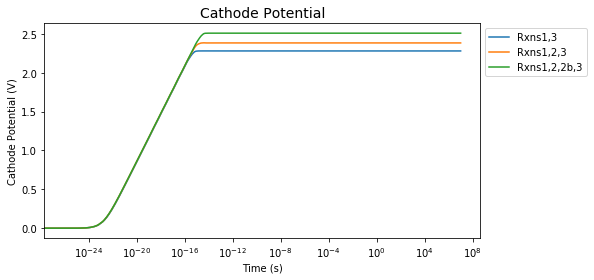

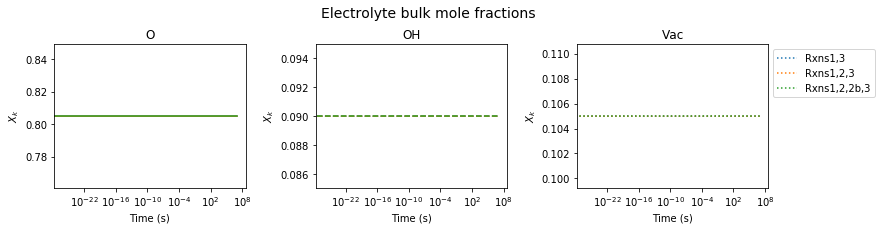

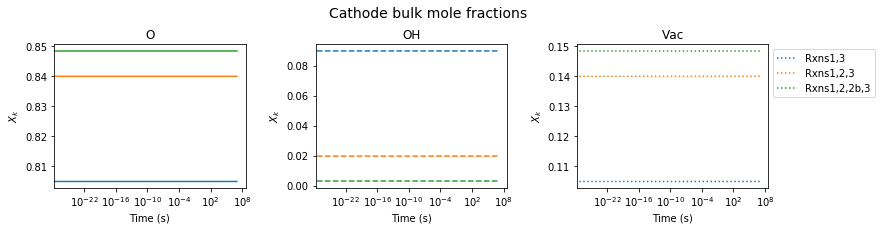

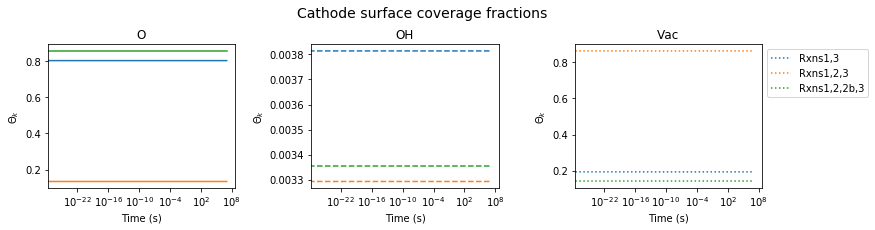

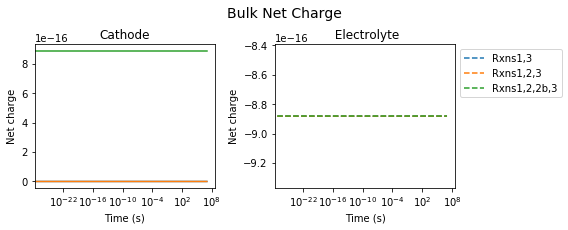

In [21]:
#equilibrate gas and ca without charge balance, then fix ca composition and equilibrate potential
sim5 = Simulation()
t_equil = [0,1e7]
t_span = [0,1e7]

for cf in ctifiles:
    sim5.initialize(cf)
    label = ctifile_label(cf,prefix)
    print(label)
    sim5.run(t_equil, charge_balance=False, static=['rho_gas','X_elyte'])#, save_as=label)
    sim5.run(t_span, charge_balance=True,static=['rho_gas','X_ca','theta_ca','X_elyte'],save_as = label)
print('simulations done')
axes = sim5.plot_runs(plot_func='semilogx', exclude=['Y_gas'])
#only the second run (post-equilibration) is plotted for each cti file

This is of course the cleanest result, but I'm not sure how much it's really telling me, since most variables are fixed in the second part of the simulation. 

Rxns1,3


/Users/stevencdecaluwe/anaconda3/envs/echem/lib/python3.6/site-packages/scipy/integrate/_ivp/bdf.py:418: RuntimeWarning: divide by zero encountered in power
  factors = error_norms ** (-1 / np.arange(order, order + 3))


Rxns1,2,3
Rxns1,2,2b,3
simulations done


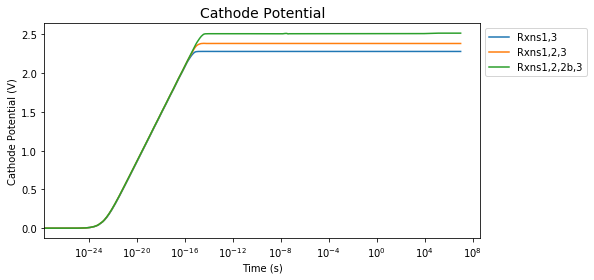

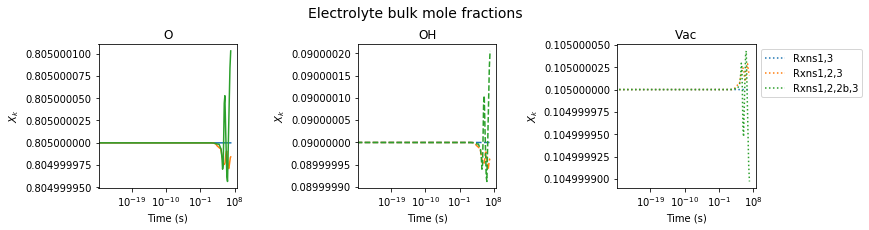

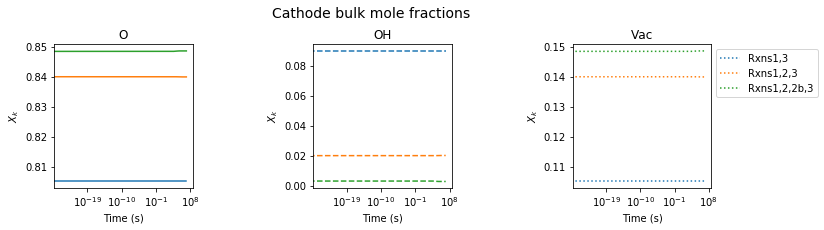

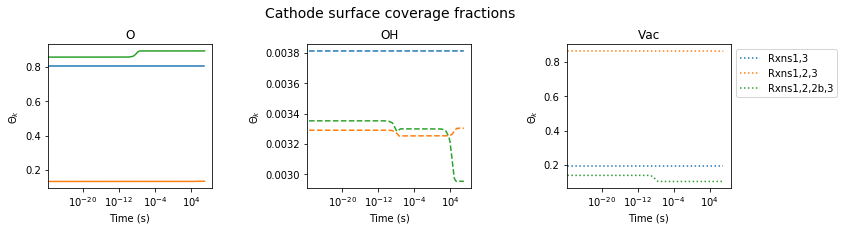

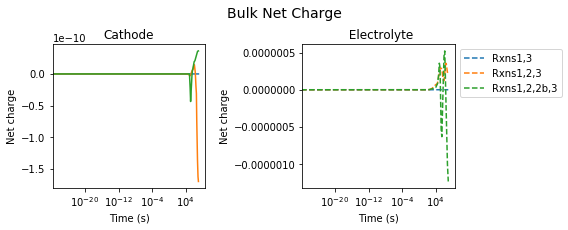

In [21]:
#equilibrate gas and ca without charge balance, then fix ca composition and equilibrate potential
sim6 = Simulation()
t_equil = [0,1e7]
t_span = [0,1e7]

for cf in ctifiles[::]:
    sim6.initialize(cf)
    label = ctifile_label(cf,prefix)
    print(label)
    sim6.run(t_equil, charge_balance=False, static=['rho_gas','X_elyte'])#, save_as=label)
    sim6.run(t_span, charge_balance=True,static=['rho_gas','X_ca','theta_ca','X_elyte'])#,save_as = label)
    sim6.run(t_span,charge_balance=True, static=['rho_gas'],save_as=label)
print('simulations done')
axes = sim6.plot_runs(exclude=['Y_gas'])
#only the second run (post-equilibration) is plotted for each cti file